# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [35]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import requests

In [ ]:
# Initialization
load_dotenv()
key = os.getenv('GOOGLE_API_KEY')

gemini = OpenAI(
    api_key=key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)
MODEL = 'gemini-2.5-flash'
print(key)


In [48]:
try:
    response = gemini.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": "Say 'Hello from Gemini!'"}]
    )
    print(response.choices[0].message.content)
except Exception as e:
    print("Gemini API test failed:", e)

Hello from Gemini!


In [21]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [22]:
# This function looks rather simpler than the one from my video, because we're taking advantage of the latest Gradio updates

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = gemini.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

In [23]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [24]:
get_ticket_price("London")

Tool get_ticket_price called for London


'$799'

In [25]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [26]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [27]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = gemini.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = gemini.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [28]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [29]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [30]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

### Image generation using Stable Diffusion from HuggingFace

In [31]:
!pip install python-dotenv requests Pillow


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
HF_API_KEY = os.getenv("HUGGINGFACE_API_KEY")
MODEL = "black-forest-labs/FLUX.1-schnell"
API_URL = f"https://api-inference.huggingface.co/models/{MODEL}"

headers = {"Authorization": f"Bearer {HF_API_KEY}"}


In [33]:
def generate_image(prompt, output_path="generated.png"):
    print(f"🎨 Generating image for: {prompt}")
    payload = {"inputs": prompt}

    response = requests.post(API_URL, headers=headers, json=payload)

    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        image.save(output_path)
        print(f"Image saved as: {output_path}")
        return image
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None


🎨 Generating image for: A cat
Image saved as: generated.png


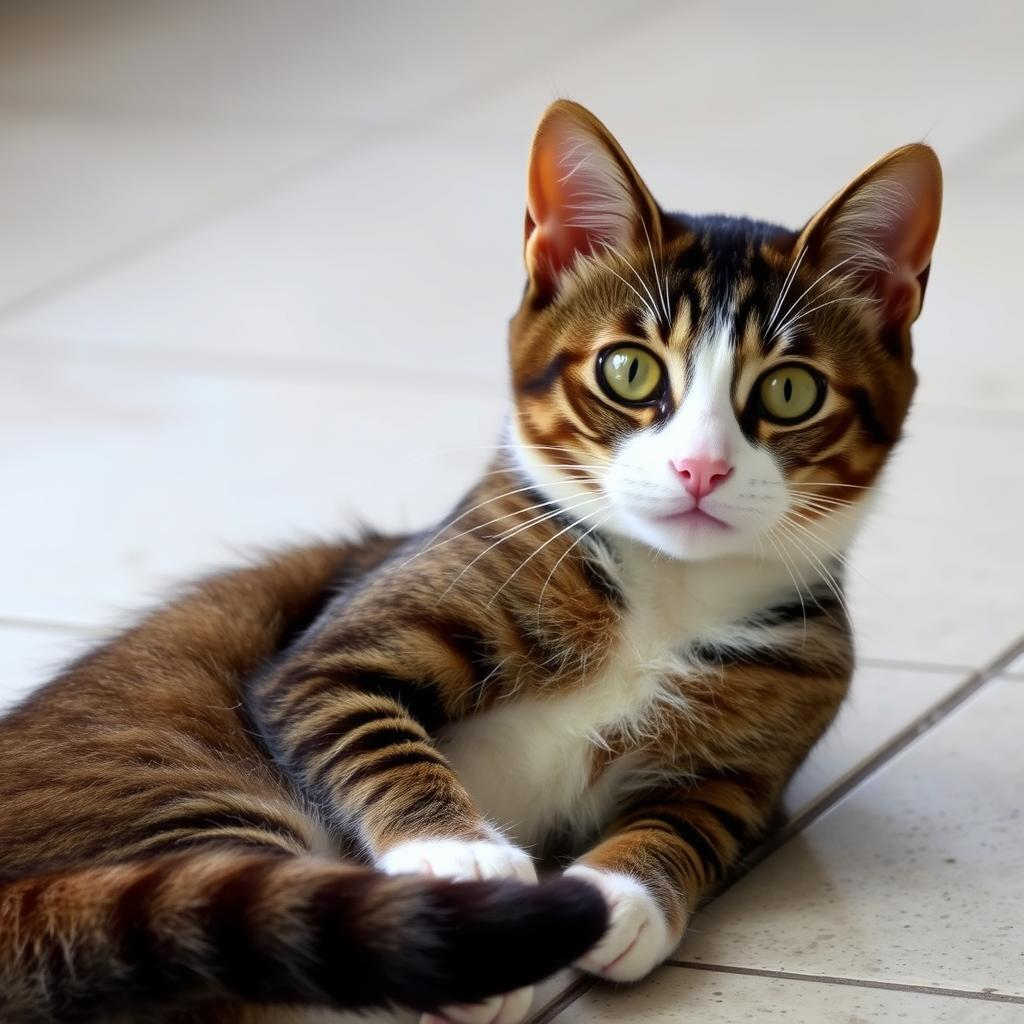

In [36]:
prompt = "A cat"
image = generate_image(prompt)
display(image)


🎨 Generating image for: An Orange cat fighting with White cat 
Image saved as: generated.png


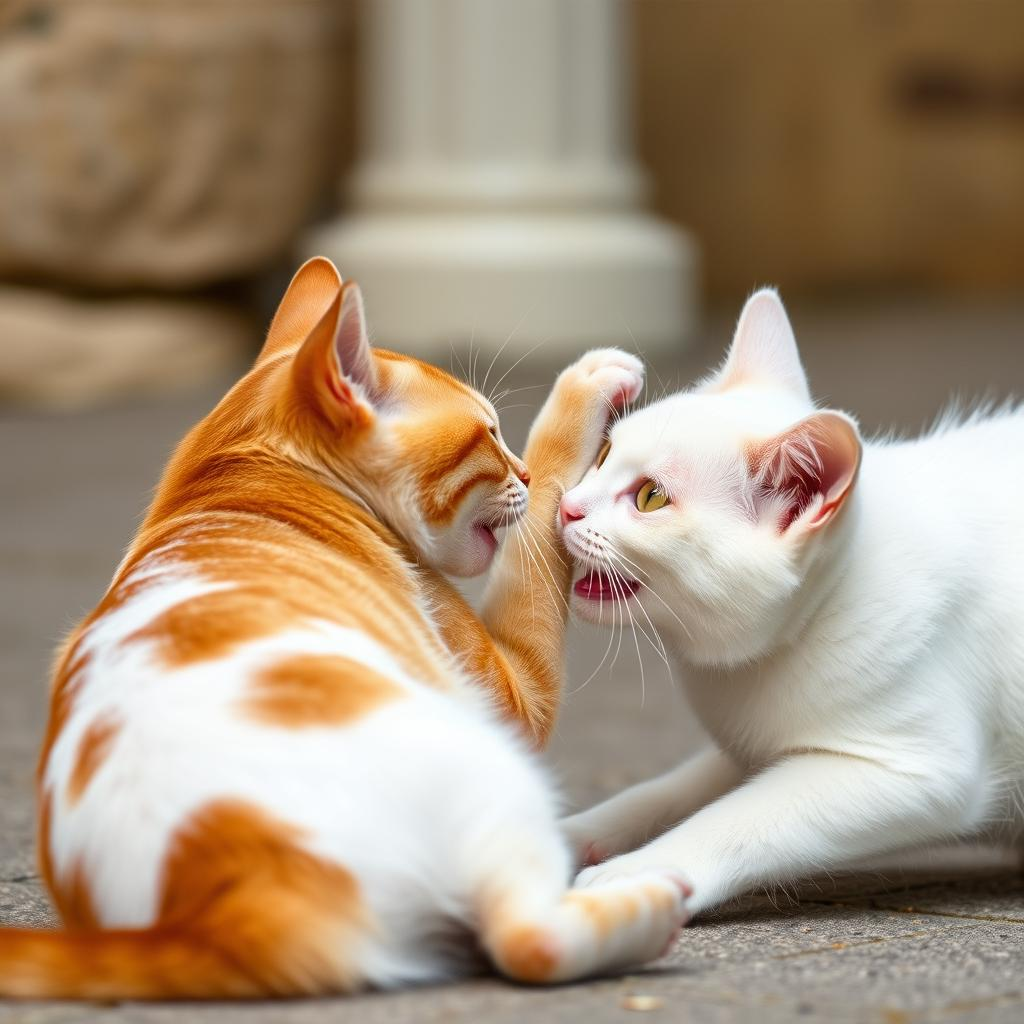

In [37]:
image = generate_image("An Orange cat fighting with White cat ")
display(image)

# Our Agent Framework

The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
2. The ability for LLMs to use Tools to give them additional capabilities
3. The 'Agent Environment' which allows Agents to collaborate
4. An LLM can act as the Planner, dividing bigger tasks into smaller ones for the specialists
5. The concept of an Agent having autonomy / agency, beyond just responding to a prompt - such as Memory

We're showing 1 and 2 here, and to a lesser extent 3 and 5. In week 8 we will do the lot!

In [51]:
def chat(message, history):
    if not isinstance(history, list):
        history = []

    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]

    response = gemini.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None

    if response.choices[0].finish_reason == "tool_calls":
        message_obj = response.choices[0].message
        tool_response, city = handle_tool_call(message_obj)
        messages.append(message_obj)
        messages.append(tool_response)

        # Generate image using Hugging Face
        image = generate_image(f"Beautiful cityscape of {city}")

        response = gemini.chat.completions.create(model=MODEL, messages=messages)

    reply = response.choices[0].message.content
    history += [{"role": "assistant", "content": reply}]
    return history, image


In [52]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")


    def do_entry(message, history):
        history += [{"role": "user", "content": message}]
        return "", history


    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=[entry, chatbot], outputs=[chatbot, image_output]
    )
    clear.click(lambda: [], outputs=[chatbot, image_output], queue=False)

ui.launch(inbrowser=True)


* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.


# Exercises and Business Applications

Add in more tools - perhaps to simulate actually booking a flight. A student has done this and provided their example in the community contributions folder.

Next: take this and apply it to your business. Make a multi-modal AI assistant with tools that could carry out an activity for your work. A customer support assistant? New employee onboarding assistant? So many possibilities! Also, see the week2 end of week Exercise in the separate Notebook.

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../thankyou.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#090;">I have a special request for you</h2>
            <span style="color:#090;">
                My editor tells me that it makes a HUGE difference when students rate this course on Udemy - it's one of the main ways that Udemy decides whether to show it to others. If you're able to take a minute to rate this, I'd be so very grateful! And regardless - always please reach out to me at ed@edwarddonner.com if I can help at any point.
            </span>
        </td>
    </tr>
</table>